In [ ]:
# Playgroud Series - Regression of Used Car Prices
    # https://www.kaggle.com/competitions/playground-series-s4e9
    # Your Goal: The goal of this competition is to predict the price of used cars based on various attributes.
    # Metric: Submissions are evaluated using the Root Mean Squared Error (RMSE): how close each prediction is to the actual values, on average.

# Imports

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost                        import CatBoostRegressor, Pool
from sklearn.model_selection         import train_test_split, GridSearchCV

pd.set_option('max_colwidth', 100) #cols to be shown
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x) #pandas decimal places

## Load Dataset

In [18]:
train = pd.read_csv('..\\dt\\kaggle\\train.csv', index_col='id')
print(train.shape)
train.reset_index(drop=True, inplace=True)
train[:2]

(188533, 12)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


# Data Cleaning

In [19]:
# Reanme Cols: no need.

In [20]:
# Meanings: all good, but:
    # Clean Title: suggests that the vehicle has never been in an accident severe enough to warrant it being classified as a total loss by an insurance company. 
        # It does not guarantee that the vehicle has never been in any accident at all
        # Also that there are no liens or disputes regarding ownership. 

In [21]:
train[:5]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [22]:
# Variations of Cat
num_feat = train.select_dtypes(include=['float64', 'int64']).columns
cat_feat = train.select_dtypes(include=['object']).columns
print(f"- Distinct values:\n{train[cat_feat].apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{train[cat_feat].apply( lambda x: x.unique() ) } " )

- Distinct values:
brand             57
model           1897
fuel_type          8
engine          1117
transmission      52
ext_col          319
int_col          156
accident           3
clean_title        2
dtype: int64 

- Variations:
brand           [MINI, Lincoln, Chevrolet, Genesis, Mercedes-Benz, Audi, Ford, BMW, Tesla, Cadillac, Land, GMC, ...
model           [Cooper S Base, LS V8, Silverado 2500 LT, G90 5.0 Ultimate, Metris Base, A6 2.0T Sport, A8 L 3.0...
fuel_type                          [Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel, Plug-In Hybrid, –, not supported]
engine          [172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel, 252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel, 320...
transmission    [A/T, Transmission w/Dual Shift Mode, 7-Speed A/T, 8-Speed A/T, 10-Speed Automatic, 1-Speed A/T,...
ext_col         [Yellow, Silver, Blue, Black, White, Snowflake White Pearl Metallic, Gray, Green, Santorini Blac...
int_col         [Gray, Beige, Black, –, Blue, White, Red, Brown, Da

In [23]:
# Missings

In [24]:
train.isna().sum().sort_values()

brand               0
model               0
model_year          0
milage              0
engine              0
transmission        0
ext_col             0
int_col             0
price               0
accident         2452
fuel_type        5083
clean_title     21419
dtype: int64

In [25]:
train.clean_title.value_counts(dropna=False)

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

In [26]:
#Remove clean_title since there is no variation.
train.drop(columns='clean_title', inplace=True)

In [27]:
train.accident.value_counts(dropna=False)

accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

In [28]:
# Set 'unknown' on NaN 
train.loc[train.accident.isna(), 'accident'] = 'Unknown'

In [29]:
train.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [30]:
#Inspect:
#train.loc[train.fuel_type == 'not supported']

#for now:
# Set 'unknown' on NaN 
train.loc[train.fuel_type.isna(), 'fuel_type'] = 'Unknown'

In [31]:
train.isna().sum().sort_values()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

In [32]:
#Dtypes
train.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
price            int64
dtype: object

In [33]:
train[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


In [34]:
#Many strings, 3 integers only, ok

# Checkpoint 1

In [35]:
train.to_parquet('..\\dt\\v1\\train_clean.parquet')

In [36]:
train = pd.read_parquet( '..\\dt\\v1\\train_clean.parquet')
print(train.shape)
train[:2]

(188533, 11)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,4999


# Descriptive Statistical

In [37]:
# num features

In [38]:
num_feat

Index(['model_year', 'milage', 'price'], dtype='object')

In [39]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( train[num_feat].apply( np.mean ) ).T
ct2 = pd.DataFrame( train[num_feat].apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( train[num_feat].apply ( np.std ) ).T
d2 = pd.DataFrame ( train[num_feat].apply ( min ) ).T
d3 = pd.DataFrame ( train[num_feat].apply ( max ) ).T
d4 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( train[num_feat].apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
nm = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
nm.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [40]:
nm

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,model_year,1974.0,2024.0,50.0,2015.8,2017.0,5.7,-1.0,0.7
1,milage,100.0,405000.0,404900.0,65705.3,57785.0,49798.0,0.9,0.7
2,price,2000.0,2954083.0,2952083.0,43878.0,30825.0,78819.3,20.3,624.0


In [41]:
# Distributions - num features

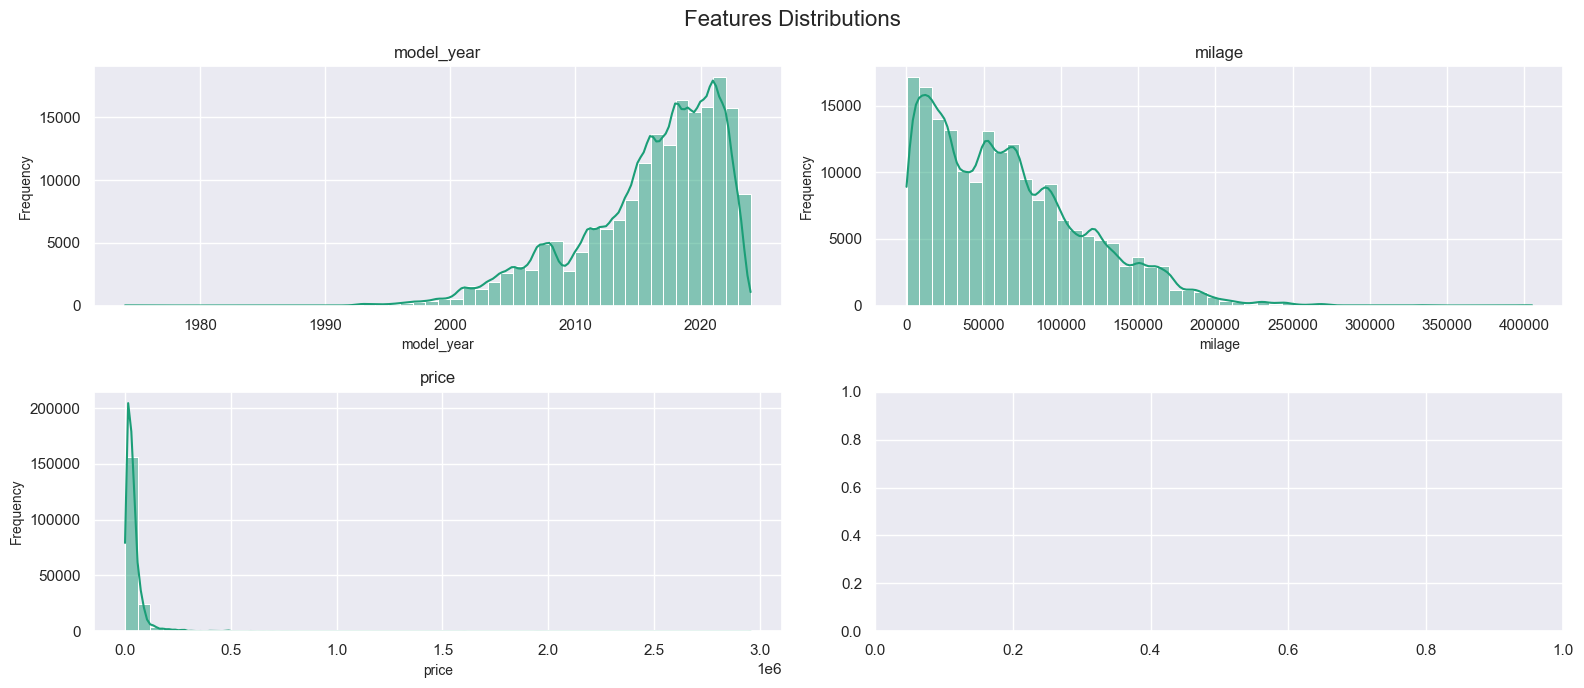

In [42]:
# Histogram
# Set the style for seaborn
sns.set(style="darkgrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 7)) 
fig.suptitle("Features Distributions", fontsize=16)

# Loop through the columns and create histograms
for ax, col in zip(axs.flatten(), train[num_feat]):
    sns.histplot(train[col], ax=ax, bins=50, kde=True, color=sns.color_palette("Dark2")[0])  # Add KDE for smoothness
    ax.set_title(col, fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True)  # Add grid lines for better readability

# Adjust layout
fig.tight_layout()  
fig.subplots_adjust(top=0.9)

In [43]:
# Distributions - cat features

KeyError: 'clean_title'

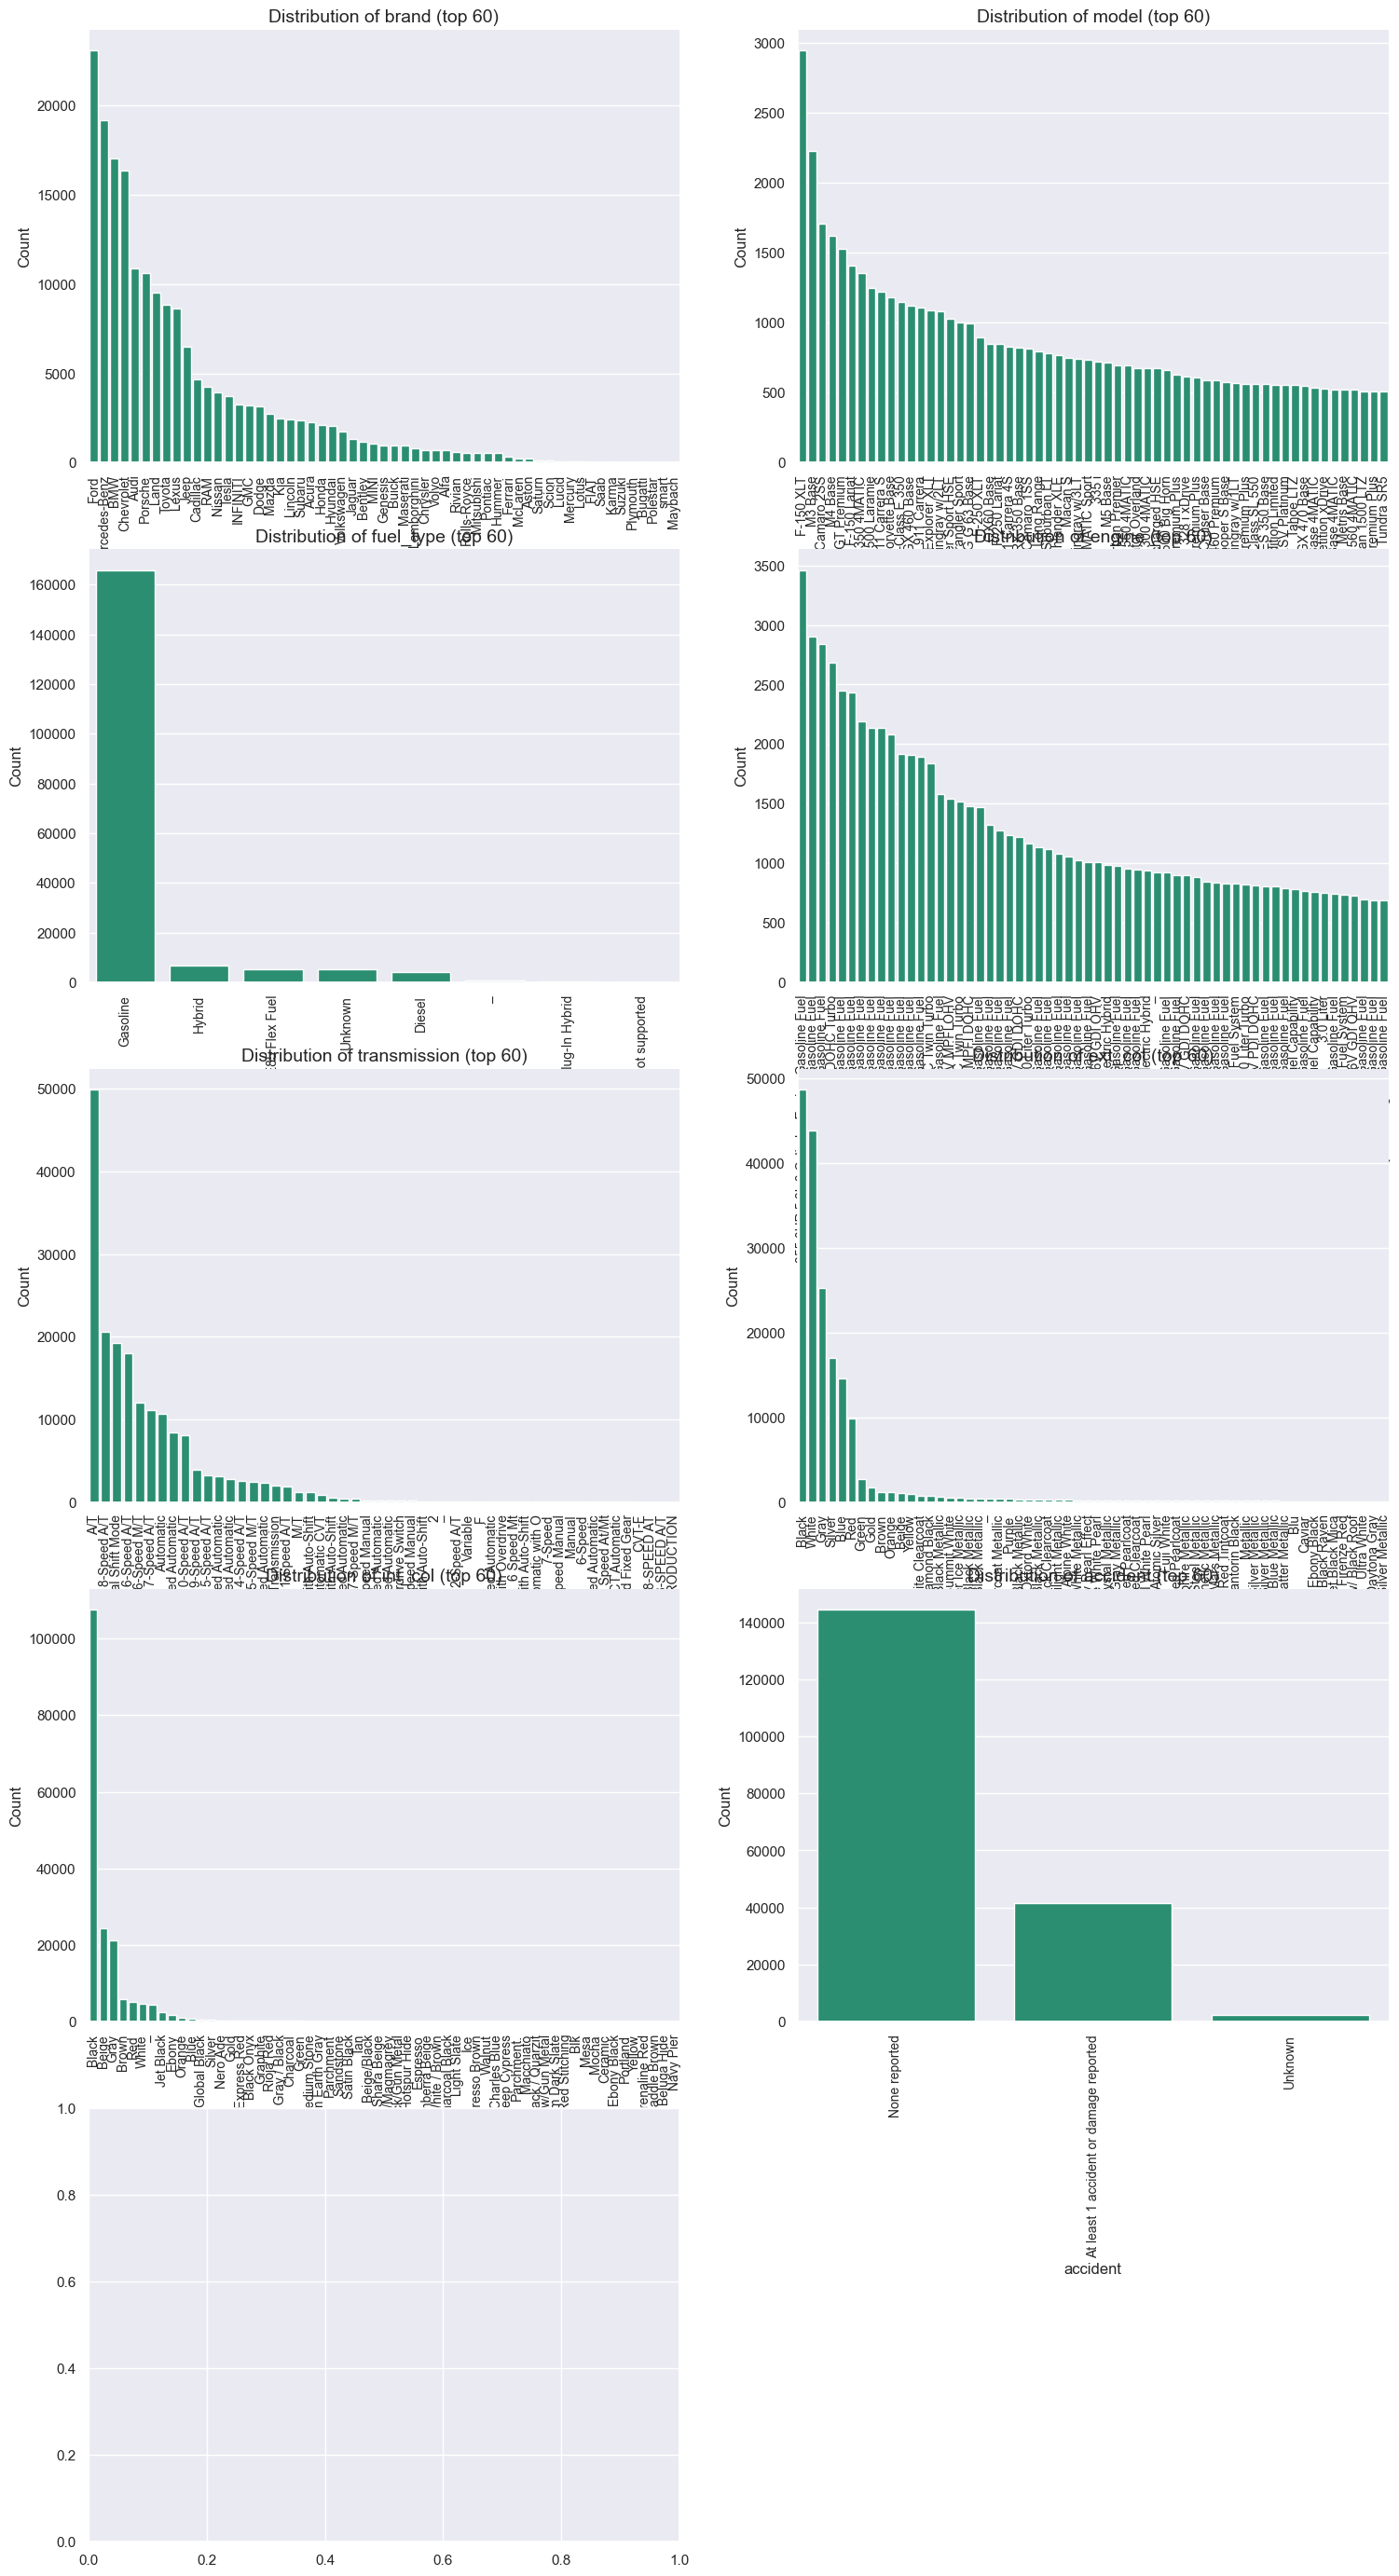

In [44]:
# Histogram
# Set the style for seaborn
sns.set(style="darkgrid")

num_cols = 2
num_rows = (len(cat_feat) + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(18, num_rows * 7))  # Adjust height based on number of rows

# Loop through each categorical column and create a bar plot
for i, col in enumerate(cat_feat):
    plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for each column
    
    # Count occurrences and sort in descending order, limit to 60
    count_data = train[col].value_counts().nlargest(60).reset_index()
    count_data.columns = [col, 'Count']  # Rename columns for clarity

    # Create a count plot with specified color
    sns.barplot(data=count_data, x=col, y='Count', color=sns.color_palette("Dark2")[0], order=count_data[col])
    
    plt.title(f'Distribution of {col} (top 60)', fontsize=14)  # Set the title with larger font size
    plt.xlabel(col, fontsize=12)  # Set x-axis label
    plt.ylabel('Count', fontsize=12)  # Set y-axis label
    plt.xticks(rotation=90, fontsize=10)  # Rotate x labels for better readability
    sns.despine()  # Remove the top and right spines for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

# Feature Engeneering

In [ ]:
#Pass for now

# EDA

In [ ]:
#pass for now

# Dataset Split

In [ ]:
train[:1]

In [ ]:
X = train.drop(columns="price") 
y = train.price

#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, test_size = 0.20) #stratify by y

In [ ]:

# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

# ML

In [73]:
# GridSearch + Cross Validation
param_grid_cb = {'max_depth': [9 ,15, 17], 'learning_rate': [0.03, 0.05, 0.07]}#  'class_weight': [None, 'balanced', {0: 1, 1: 2.5}  , 'max_leaf_nodes': [10, 40, 100]  , 'min_samples_leaf':[5, 20, 45], }
    #'class_weight': {0: 1, 1: 2.5} balancing manually, to give more importance to the minority class.
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance
print("Parameter grid RF:\n{}".format(param_grid_cb))

Parameter grid RF:
{'max_depth': [9, 15, 17], 'learning_rate': [0.03, 0.05, 0.07]}


In [75]:
cat_feat #get cat features
cat_features = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident'] #removed clean_title, cause was removed on data cleaning

In [76]:
cb_model = GridSearchCV(CatBoostRegressor(n_estimators=20, random_state=98, cat_features=cat_features), param_grid_cb, cv=2, n_jobs=1, scoring='neg_root_mean_squared_error', return_train_score=True)
cb_model.fit(X_train, y_train)

0:	learn: 75510.1621971	total: 59.7ms	remaining: 1.13s
1:	learn: 75237.9115203	total: 117ms	remaining: 1.05s
2:	learn: 74979.8601885	total: 178ms	remaining: 1.01s
3:	learn: 74728.2465001	total: 241ms	remaining: 965ms
4:	learn: 74485.4569007	total: 305ms	remaining: 916ms
5:	learn: 74246.1165075	total: 368ms	remaining: 858ms
6:	learn: 74033.3522873	total: 442ms	remaining: 821ms
7:	learn: 73824.8848483	total: 526ms	remaining: 788ms
8:	learn: 73621.6612876	total: 615ms	remaining: 751ms
9:	learn: 73450.9406699	total: 683ms	remaining: 683ms
10:	learn: 73264.1533000	total: 779ms	remaining: 637ms
11:	learn: 73089.5343347	total: 853ms	remaining: 568ms
12:	learn: 72930.5122447	total: 950ms	remaining: 512ms
13:	learn: 72775.7405980	total: 1.04s	remaining: 448ms
14:	learn: 72626.5744017	total: 1.12s	remaining: 374ms
15:	learn: 72483.2656362	total: 1.21s	remaining: 302ms
16:	learn: 72353.9519590	total: 1.31s	remaining: 231ms
17:	learn: 72230.0965502	total: 1.41s	remaining: 157ms
18:	learn: 72107.30

C:\Users\norton\repos\play_s4e9_car_price_classifc\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\norton\repos\play_s4e9_car_price_classifc\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\norton\repos\play_s4e9_car_price_classifc\.venv\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, 

0:	learn: 75992.1974361	total: 84.7ms	remaining: 1.61s
1:	learn: 75415.4358969	total: 169ms	remaining: 1.52s
2:	learn: 74924.7798820	total: 249ms	remaining: 1.41s
3:	learn: 74492.7691858	total: 340ms	remaining: 1.36s
4:	learn: 74120.3031976	total: 440ms	remaining: 1.32s
5:	learn: 73756.8417181	total: 539ms	remaining: 1.26s
6:	learn: 73452.0729841	total: 629ms	remaining: 1.17s
7:	learn: 73182.3566986	total: 709ms	remaining: 1.06s
8:	learn: 72917.4510852	total: 793ms	remaining: 969ms
9:	learn: 72701.7358122	total: 876ms	remaining: 876ms
10:	learn: 72501.0632624	total: 956ms	remaining: 782ms
11:	learn: 72334.1958859	total: 1.03s	remaining: 689ms
12:	learn: 72173.1962020	total: 1.13s	remaining: 606ms
13:	learn: 72035.3862837	total: 1.23s	remaining: 529ms
14:	learn: 71910.1238178	total: 1.33s	remaining: 443ms
15:	learn: 71785.9609271	total: 1.42s	remaining: 355ms
16:	learn: 71637.7122227	total: 1.5s	remaining: 265ms
17:	learn: 71516.4183622	total: 1.59s	remaining: 177ms
18:	learn: 71398.428

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000018634709700>,
             n_jobs=1,
             param_grid={'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [9, 15, 17]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [77]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("RF Best parameters (val): {}".format(cb_model.best_params_))
print("RF Best cross-validation score (val): {:.3f}".format(cb_model.best_score_))

RF Best parameters (val): {'learning_rate': 0.07, 'max_depth': 9}
RF Best cross-validation score (val): -71654.912


In [78]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
pd.DataFrame(cb_model.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
6,1,"{'learning_rate': 0.07, 'max_depth': 9}",-71080.4,-71654.9
7,2,"{'learning_rate': 0.07, 'max_depth': 15}",-69699.2,-71705.5
4,3,"{'learning_rate': 0.05, 'max_depth': 15}",-70698.7,-72234.1
3,4,"{'learning_rate': 0.05, 'max_depth': 9}",-71918.4,-72301.9
1,5,"{'learning_rate': 0.03, 'max_depth': 15}",-72149.0,-73151.4


In [79]:
# Access the best estimator
best_model = cb_model.best_estimator_

In [80]:
#Get feature importances:
# Create a Pool object with your training data and specify categorical features
train_pool = Pool(X_train, cat_features=cat_features)

# Get feature importances
feature_importances = best_model.get_feature_importance(data=train_pool)

#Feature importances:
sorted_importances = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, importance in sorted_importances]
print("Top features ordered by importance:", top_features)

Top features ordered by importance: ['milage', 'brand', 'model_year', 'transmission', 'fuel_type', 'engine', 'int_col', 'accident', 'model', 'ext_col']


# Kaggle Test Prediction

In [106]:
X_prod = pd.read_csv('..\\dt\\kaggle\\test.csv')
X_prod[:3]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN


In [107]:
#get id to final df:
X_prod_id = X_prod['id'].copy()

#Clean data:

#Remove cols
X_prod.drop(columns='clean_title', inplace=True)
# Missings
X_prod.loc[X_prod.accident.isna(), 'accident'] = 'Unknown'
X_prod.loc[X_prod.fuel_type.isna(), 'fuel_type'] = 'Unknown'
#remove id to predict:
X_prod.drop(columns='id', inplace=True)
X_prod[:2]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported


In [108]:
#predict on prod data:
y_hat_prod = best_model.predict(X_prod)

In [109]:
#Prices predicted
print(y_hat_prod.shape)
y_hat_prod[:5]

(125690,)


array([26014.27157265, 76274.04544072, 56551.7056012 , 38200.21695341,
       36669.131058  ])

In [112]:
# Prepare for submission: id + predictions:
# Create final dataset
df_sub = pd.concat([ pd.Series(X_prod_id, name='id') , pd.Series(y_hat_prod, name='price') ], axis=1)
df_sub[:3]

,id,price
0,188533,26014.3
1,188534,76274.0
2,188535,56551.7


In [113]:
# Export to submit to Kaggle
df_sub.to_csv('..\\dt\\v1\\sub_v1.csv', index=False)

In [137]:
print(f"Public position: {627} of {847}  -->  {round(653/847*100)}th of 100 ")

Public position: 627 of 847   -->  77th of 100 
